In [1]:
!pip install zfit

     |████████████████████████████████| 317kB 5.2MB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
     |████████████████████████████████| 327kB 33.4MB/s 
     |████████████████████████████████| 430kB 36.2MB/s 
     |████████████████████████████████| 102kB 10.0MB/s 
     |████████████████████████████████| 245kB 40.2MB/s 
     |████████████████████████████████| 686kB 33.8MB/s 
     |████████████████████████████████| 194kB 44.1MB/s 
  Created wheel for colored: filename=colored-1.4.2-cp37-none-any.whl size=14022 sha256=2addf688ece63595210b8981ad92e617a9e3c0cbde7dcb1997af6ce04c1a79df
  Stored in directory: /root/.cache/pip/wheels/ec/10/5e/d17d5ef644e1051a753bd98f3796789ec39bc3337cd36637f3
  Created wheel for ordered-set: filename=ordered_set-4.0.2-py2.py3-none-any.whl size=8218 sha256=e58ece848b0bd65f3c8ad9a2f22274b2845e42fc6bcad788a5c1ab9e26ddb198
  Stored in directory: /root/.cache/pip/wheels/e1/c6/9b/651d8a21d59b51a75ab9c070838f9231b8126421bc0569af47
  Created wheel for algop

In [2]:
import zfit 
from zfit.settings import run
import numpy as np
import tensorflow as tf
import scipy.stats
from zfit import z
import random
from typing import List  
import random, string
import time
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/zfit/__init__.py:37: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."


Вспомогательные функции для графиков и обработки результатов

In [3]:
# метод для вывода графика дисперсии
def Sigma_plt(result):
  plt.title("Дисперсия смещения от количества точек в генерации")
  plt.xscale('log')
  plt.xlabel('N')
  plt.ylabel('Sigma')
  plt.plot(result[:, 0], result[:,2])
# метод для вывода графика мат ожидания
def Mean_plt(result):
  plt.title("Среднее смещение от количества точек в генерации")
  plt.xscale('log')
  plt.xlabel('N')
  plt.ylabel('Mean')
  plt.plot(result[:, 0], result[:,1])
# метод для вывода графиков среднего смещения
def Result_plt(mean_bias_list):
  fig, axes = plt.subplots(2, 4, figsize = (30, 10))
  sample_size = [10, 25, 50, 100, 500, 1000, 5000, 10000]

  for i, axis in enumerate(axes.flat):
    mean_bias = mean_bias_list[i]
    (mu, sigma) = norm.fit(mean_bias) 
    pdf_x = np.linspace(np.min(mean_bias),np.max(mean_bias),50)
    n, bins, patches = axis.hist(mean_bias, bins = 50, density=True,)
    axis.set_title(sample_size[i])
    axis.plot(pdf_x, norm.pdf(pdf_x, loc = mu, scale = sigma ), 'r-', lw=5, alpha=0.6, label='norm pdf')


-----

# Оценка размера контрольных данных при анализе общего распределения

Работа состоиз из следующих частей частей:
1. Использования гистрограммы как контрольной модели
2. Аналитическая функция как контрольная модель
3. Эксперимент с комбинированным фитированием
4. Использование начальной модели в качестве контрольной модели



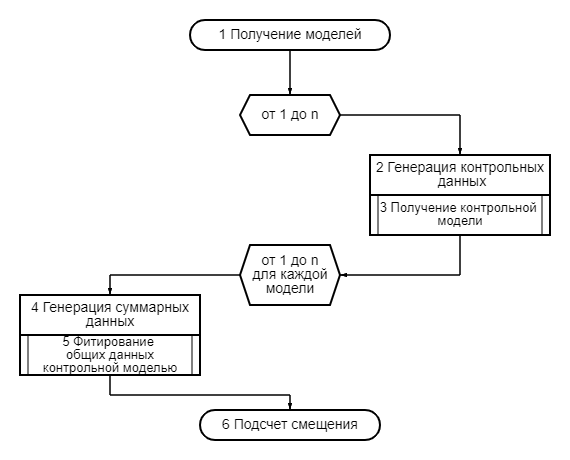----

Общая схема эксперимента: На первом этапе мы получаем модели. Один из источников мы будем использовать, как источник контрольных данных. На втором этапе симулируем n контрольных точек из этого модели этого источника, аппроксимируем их, получая параметры модели. Таким образом я получил контрольную модель это шаг 3. На четвертом шаге я с помощью модели, полученной на третьем шаге произвожу серию псевдоэкспериментов - генерирую данные со всех начальных источников, складываю контрольную модель с остальными начальными моделями и аппроксимирую сгенерируемые данные с начальных источников суммарной полученной моделью - шаг 5, аппроксимирую относительного свободного параметра (относительного расположение в пространстве моих моделей).
На последнем этапе я фиксирую разность полученного в ходе фитирования свободного параметра и изначального свободного параметра. И повторяю n раз мой эксперимент по нахождению этой разности, тем самым получая среднее значение для одной полученной контрольной модели. Повторяя серию экспериментов для различных полученных контрольных моделей, я получаю распределние средних значений для этих контрольных моделей. Взяв среднеквадратичное отклонение этого распределения, я получаю оценку моего смещения.

###Использование гистограммы в качестве контрольной модели
Из контрольных данных создаем гистограмму и проводим исследование 

In [4]:
# Класс для создания из данных нормализованную гистограмму
class HistPDF(zfit.pdf.BasePDF):

    def __init__(self, hist_args, hist_bins, obs, name='HistPDF'):
        self.rv_hist = scipy.stats.rv_histogram([hist_args, hist_bins]) 
        super().__init__(obs=obs, name=name)

    def _unnormalized_pdf(self, x):
        run.assert_executing_eagerly()
        x = z.unstack_x(x)
        probs = self.rv_hist.pdf(x)
        probs = probs.astype(np.float64)
        return tf.convert_to_tensor(probs)


def randomnames():
  length = random.randint(4,100)
  letters = string.ascii_lowercase
  return [''.join(random.choice(letters) for i in range(length)) for _ in range(4)]
# метод для создания моделей
def init_model(lower_limit: List[float] = [None]*4, upper_limit: List[float] = [None]*4, step_size = 0.001):
  obs = zfit.Space("x", limits=(0, 10))
  names_parameters = randomnames()
  values = [5, 1, -0.2, 0.5]
  parametrs = []

  for name, value, low, upp, step in zip(names_parameters, values, lower_limit, upper_limit, [step_size]*4):
    while True:
      try:
        parametrs.append(zfit.Parameter(name, value, low, upp, step))
      except:
        time.sleep(1)
        continue
      break

  mu, sigma, lamd, frac = parametrs
  gauss = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)
  exponential = zfit.pdf.Exponential(lam=lamd, obs=obs)
  model = zfit.pdf.SumPDF([gauss, exponential], fracs=frac)

  return gauss, exponential, model, mu, sigma, lamd, frac, obs

In [5]:
gauss, exponential, model, mu, sigma, lamd, frac, obs = init_model([0, 0.1, -0.5, 0], [10, 2, 0.5, 1])
gauss_true, exponential_true, model_true, mu_true, sigma_true, lamd_true, frac_true, obs_true = init_model(step_size = 0)

In [6]:

exp_data = exponential.sample(n=5000 * (1 - frac)).numpy()
gauss_data = gauss.sample(n=5000 * frac).numpy()
data = model.create_sampler(5000, limits=obs)

###Название эксперимента
Пояснения про эксперимент 

In [ ]:
zfit.run.set_graph_mode(False)
zfit.settings.options['numerical_grad'] = True
# на вход подаются две модели и их суммарная модель
class bias_estimation_of_models_hist():
  def  __init__(self, frac, obs, gauss_true, model_true, exponential_true):
    self.frac = frac
    self.obs = obs
    self.gauss_true = gauss_true
    self.model_true = model_true
    self.exponential_true = exponential_true
    self.data = model_true.create_sampler(5000, limits=obs)
# метод для симуляции контрольных данных
  def fit_models(self):
    sample_size = [10, 25, 50, 100, 500, 1000, 5000, 10000]
    array_result = np.zeros((len(sample_size), 3))
    i = 0
    mean_bias_list = []
    for n in sample_size:
      print('Число контрольных данных ',n)
      data_hist = self.gauss_true.create_sampler(n, limits=self.obs)

      mean_bias = self.generate_sim_model(data_hist)
      (mu_si, sigma_si) = norm.fit(mean_bias)

      array_result[i, 0] = n
      array_result[i, 1] = mu_si
      array_result[i, 2] = sigma_si
      i += 1
      mean_bias_list.append(mean_bias)
    return array_result, mean_bias_list
# метод для создания контрольной модели
  def generate_sim_model(self, data_hist):
    mean_bias = []
    for i in range(0, 100):
      data_hist.resample()
      data_np = data_hist[:, 0].numpy()
      histogramm = np.histogram(data_np, bins=100)
      hist_init = HistPDF(histogramm[0], histogramm[1], obs = self.obs)
      modelHist = zfit.pdf.SumPDF([hist_init, self.exponential_true], fracs=self.frac)
      loss_function = zfit.loss.UnbinnedNLL(model=modelHist, data=self.data) 
      minimizer = zfit.minimize.Minuit(verbosity = 0)
      res = self.count_frac(minimizer, loss_function)
      (mu_ar, sigma_ar) = norm.fit(res)
      mean_bias.append(mu_ar)

    return mean_bias


# метод для подсчета разницы между истинной модели
  def count_frac(self, minimizer, loss_function):
    res = []
    for i in range(0, 30):
      self.data.resample()
      result = minimizer.minimize(loss_function, params=[self.frac])  
      value_stat = list(result.error().keys())[0] 
      error_stat = list(result.error().values())[0] 
      frac_value = float(value_stat.value()) 
      frac_up_error = float(error_stat['upper']) 
      frac_low_error = float(error_stat['lower']) 
      if (frac_value - 0.5 > 0): 
          frac_error = frac_up_error 
      else: 
          frac_error = abs(frac_low_error) 
      final_value = (0.5-frac_value)/(frac_error) 
      res.append(final_value)
    return res




In [ ]:
bias = bias_estimation_of_models_hist(frac, obs, gauss_true, model_true, exponential)
result, mean_bias_list = bias.fit_models()

Число контрольных данных  10


/usr/local/lib/python3.7/dist-packages/zfit/minimizers/fitresult.py:1099: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  "in the future, add it explicitly as in `errors(method='minuit_minos')`", FutureWarning)


Число контрольных данных  25
Число контрольных данных  50
Число контрольных данных  100
Число контрольных данных  500
Число контрольных данных  1000
Число контрольных данных  5000
Число контрольных данных  10000


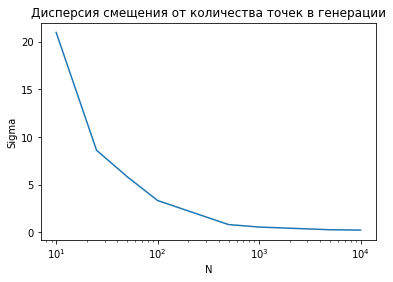

In [ ]:
Sigma_plt(result)

На рисунке представлены зависимость смещения от числа контрольных данныъ. Мы видим тенденцию - смещение уменьшается и сводится к нулю при большом количестве опорных точек. Видно, что при малом количестве точек - например при 10, смещение для гистограмм в разы больше, это обусловлено неточном описанием модели, из-за малого числа данных. Но при большом количестве контрольных данных смещение для двух зависимостей стремиться к нулю, ведь тогда опорные данные почти полностью описывают изначальную модель. Видно что при более, чем 1000 точках смещение сильно не меняется, этого количества данных вполне достаточно, чтобы точно описать общие данные 

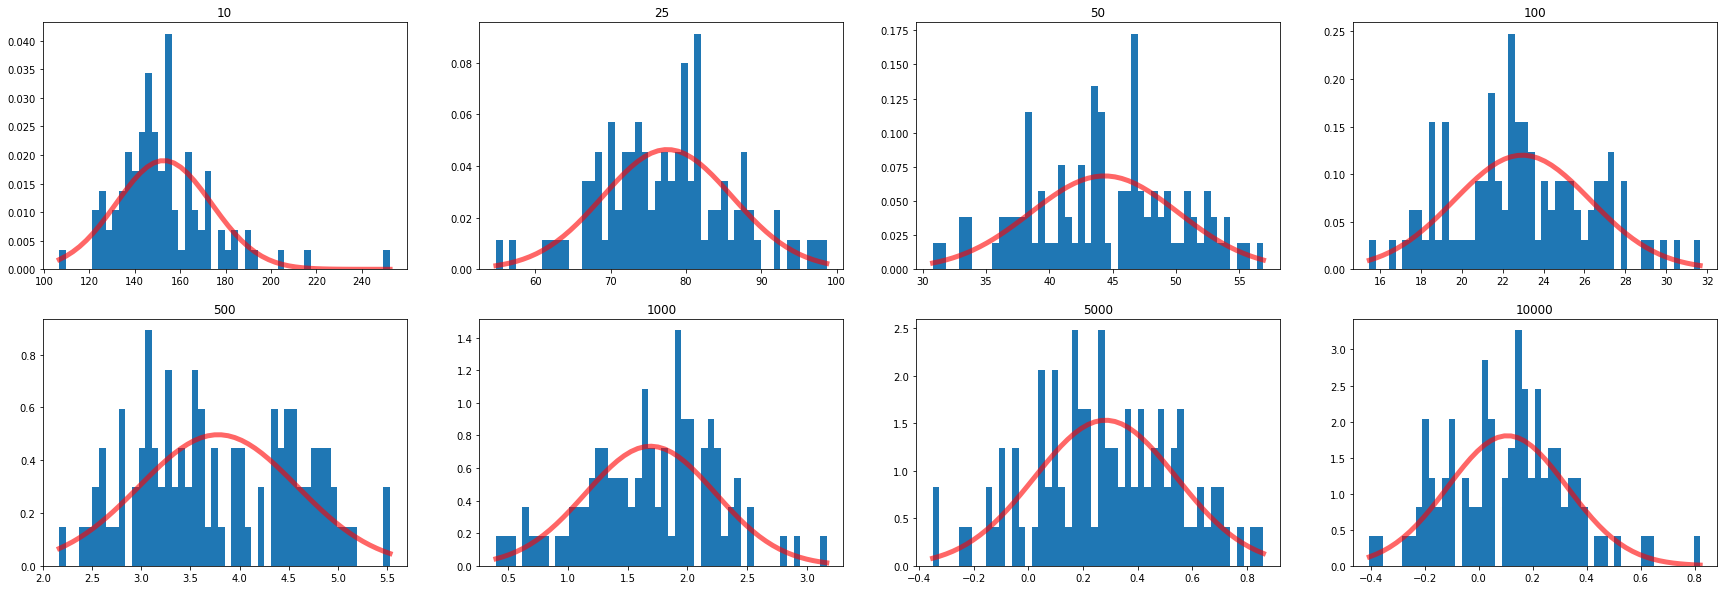

In [ ]:
Result_plt(mean_bias_list)

На рисунках изображены распределнения средних значений смещений, для контрольных моделей полученных из фиксированного числа контрольных данных, это число можно увидеть на графике. Из них видно, что при малом количестве данных, оценка очень сильно смещена

###Использование аналитической функции в качестве контрольной модели
В данном эксперименте из контрольных данных создается модель, при этом параметры заранее неизвестны

In [ ]:

zfit.run.set_graph_mode(False)
zfit.settings.options['numerical_grad'] = True


class bias_estimation_of_models_analyt():
  def  __init__(self, frac, obs, mu, sigma, gauss_true, model_true, exponential_true, gauss, model, exponential):
    self.frac = frac
    self.obs = obs
    self.mu = mu
    self.sigma = sigma
    self.gauss_true = gauss_true
    self.model_true = model_true
    self.exponential_true = exponential_true
    self.gauss = gauss
    self.model = model
    self.exponential = exponential
    self.data = model_true.create_sampler(5000, limits=obs)

  def fit_models(self):
    sample_size = [10, 25, 50, 100, 500, 1000, 5000, 10000]
    array_result = np.zeros((len(sample_size), 3))
    i = 0
    mean_bias_list = []
    for n in sample_size:
      print('Число контрольных данных ',n)
      data_sim = self.gauss_true.create_sampler(n, limits=self.obs)
      loss_gauss = zfit.loss.UnbinnedNLL(model=self.gauss, data=data_sim)
      loss_model = zfit.loss.UnbinnedNLL(model=self.model, data=self.data) 
      minimizer = zfit.minimize.Minuit(verbosity = 0)


      mean_bias = self.generate_sim_model(data_sim, loss_gauss, loss_model, minimizer)
      (mu_si, sigma_si) = norm.fit(mean_bias)

      array_result[i, 0] = n
      array_result[i, 1] = mu_si
      array_result[i, 2] = sigma_si
      i += 1
      mean_bias_list.append(mean_bias)
    return array_result, mean_bias_list

  def generate_sim_model(self, data_sim, loss_gauss, loss_model, minimizer):
    mean_bias = []
    for i in range(0, 100):
      print('Номер прогона', i)
      data_sim.resample()
      result_sim = minimizer.minimize(loss_gauss)
      mu_sim = float(list(result_sim.error().keys())[0])
      sigma_sim = float(list(result_sim.error().keys())[1]) 
      res = self.count_frac(minimizer, loss_model, sigma_sim, mu_sim)
      (mu_ar, sigma_ar) = norm.fit(res)
      mean_bias.append(mu_ar)

    return mean_bias



  def count_frac(self, minimizer, loss_function, sigma_sim, mu_sim):
    res = []
    for i in range(0, 30):
      self.data.resample()
      self.sigma.set_value(sigma_sim)
      self.mu.set_value(mu_sim)

      result = minimizer.minimize(loss_function, params=[self.frac])  

      value_stat = list(result.error().keys())[0] 
      error_stat = list(result.error().values())[0] 
      frac_value = float(value_stat.value()) 
      frac_up_error = float(error_stat['upper']) 
      frac_low_error = float(error_stat['lower']) 
      if (frac_value - 0.5 > 0): 
          frac_error = frac_up_error 
      else: 
          frac_error = abs(frac_low_error) 
      final_value = (0.5-frac_value)/(frac_error) 
      res.append(final_value)
    return res




In [ ]:
bias = bias_estimation_of_models_analyt(frac, obs, mu, sigma, gauss_true, model_true, exponential_true, gauss, model, exponential)
result, mean_bias_list = bias.fit_models()

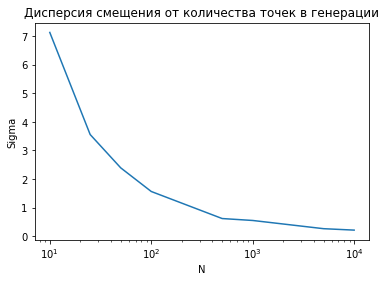

In [ ]:
Sigma_plt(result)

Из синего графика для симуляционной модели видно, что ошибка смещения относительного вклада уменьшается относительно количества точек, это означает что чем больше точек симуляции мы имеем изначально, тем меньше дальнейшая систематическая ошибка при фитировании

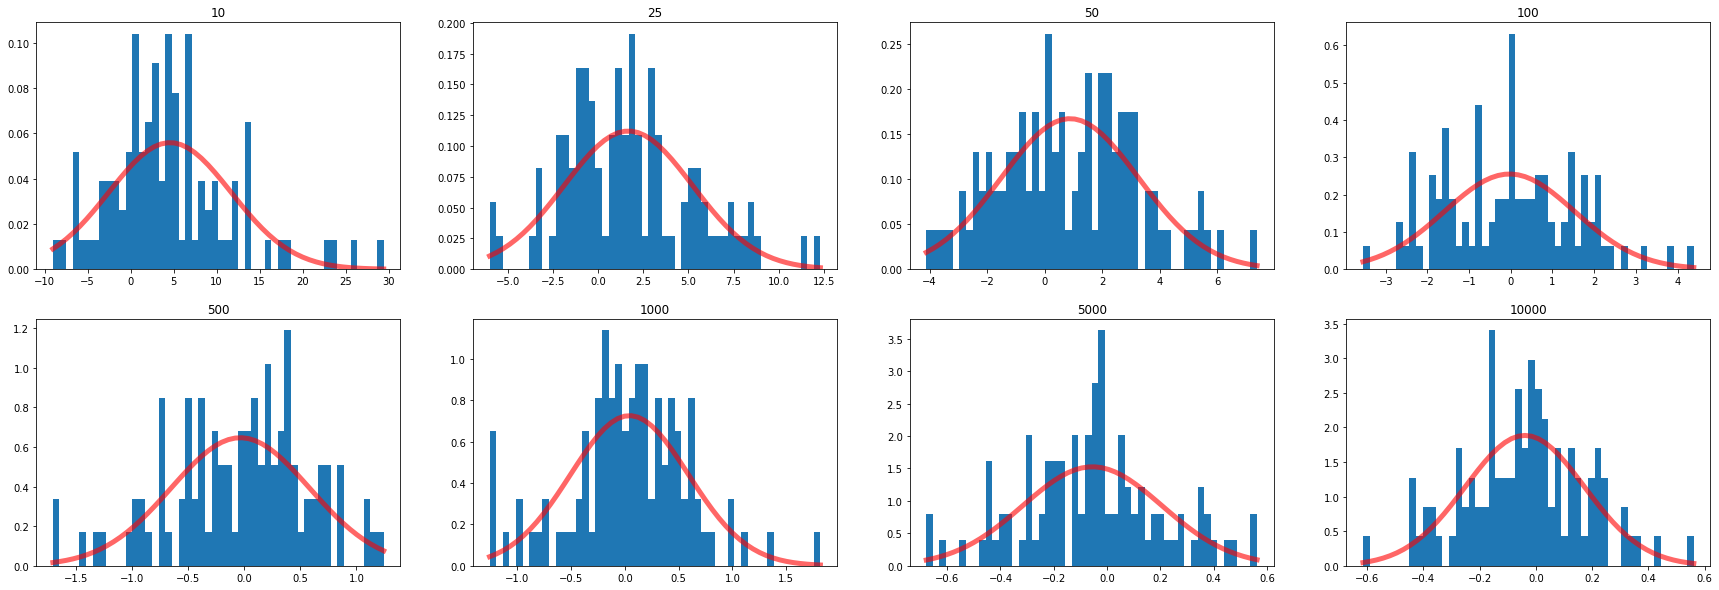

In [ ]:
Result_plt(mean_bias_list)

На рисунках изображены распределнения средних значений смещений, для контрольных моделей полученных из фиксированного числа контрольных данных, это число можно увидеть на графике. Из них видно, что при малом количестве данных, оценка очень сильно смещена



---




###Комбинированное фитирования
Сложение функций правдапобобия для подбора параметров

In [ ]:
class bias_estimation_of_models_combine():
  def  __init__(self, frac, obs, gauss_true, model_true, gauss, model):
    self.frac = frac
    self.obs = obs
    self.gauss_true = gauss_true
    self.gauss = gauss
    self.model = model
    self.data = model_true.create_sampler(5000, limits=obs)

  def fit_models(self):
    sample_size = [10, 25, 50, 100, 500, 1000, 5000, 10000]
    array_result = np.zeros((len(sample_size), 3))
    i = 0
    mean_bias_list = []
    for n in sample_size:
      print('Число контрольных данных ',n)
      data_sim = self.gauss_true.create_sampler(n, limits=self.obs)
      loss_gauss = zfit.loss.UnbinnedNLL(model=self.gauss, data=data_sim)
      loss_model = zfit.loss.UnbinnedNLL(model=self.model, data=self.data) 
      loss_combine = loss_gauss + loss_model
      minimizer = zfit.minimize.Minuit(verbosity = 0)


      mean_bias = self.generate_sim_model(data_sim, loss_combine, minimizer)
      (mu_si, sigma_si) = norm.fit(mean_bias)

      array_result[i, 0] = n
      array_result[i, 1] = mu_si
      array_result[i, 2] = sigma_si
      i += 1
      mean_bias_list.append(mean_bias)
    return array_result, mean_bias_list

  def generate_sim_model(self, data_sim, loss_combine, minimizer):
    res = []
    for i in range(0, 100):
      self.data.resample()
      data_sim.resample()
      result_sim = minimizer.minimize(loss_combine, params=[self.frac])
      value_stat = list(result_sim.error().keys())[0] 
      error_stat = list(result_sim.error().values())[0]   

      frac_value = float(value_stat.value()) 
      frac_up_error = float(error_stat['upper']) 
      frac_low_error = float(error_stat['lower']) 
      if(frac_value - 0.5 > 0): 
          frac_error = frac_up_error 
      else: 
          frac_error = abs(frac_low_error) 
      final_value = (0.5-frac_value)/(frac_error) 
      res.append(final_value)

    return res





In [ ]:
bias = bias_estimation_of_models_combine(frac, obs, gauss_true, model_true, gauss, model)
result, mean_bias_list = bias.fit_models()

Число контрольных данных  10


/usr/local/lib/python3.7/dist-packages/zfit/minimizers/fitresult.py:1099: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  "in the future, add it explicitly as in `errors(method='minuit_minos')`", FutureWarning)


Число контрольных данных  25
Число контрольных данных  50
Число контрольных данных  100
Число контрольных данных  500
Число контрольных данных  1000
Число контрольных данных  5000
Число контрольных данных  10000


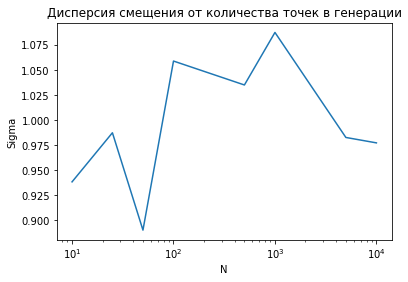

In [ ]:
Sigma_plt(result)

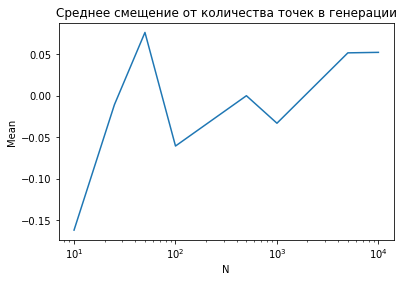

In [ ]:
Mean_plt(result)

Как видно из графика мат ожидание отклонения находится в районе нуля для различного числа контрольных данных, что говорит о том что мы всегда точно можем вычислить отнсительный вклад. 